# Proyek Klasifikasi Gambar: Image Classification Cat vs dog vs tiger
- **Nama:** wildan fadhil nazaruddin
- **Email:** wildanfadhil76@gmail.com
- **ID Dicoding:** @WildanFadhilNazaruddin

## Import Semua Packages/Library yang Digunakan

In [2]:
import zipfile
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from skimage import io
import cv2
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage import img_as_ubyte
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from PIL import Image

In [3]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [6]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [7]:
import os
import shutil

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### load images dataset

In [34]:
# Path ke dataset.zip Hasil Download dari Kaggle
zip_path = '/workspaces/Image-Classification-for-Cat-Dog-and-Tiger/dataset-klasifikasi-gambar-hewan.zip'

# Path untuk ekstraksi
extract_path = '/workspaces/Image-Classification-for-Cat-Dog-and-Tiger/submission'

# Ekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Set the path to the dataset folder
dataset_path = os.path.join(extract_path, 'dataset')

# Listing the files in the dataset folder to ensure it's correctly extracted
print(os.listdir(dataset_path))

['training_set', 'test_set']


In [35]:
import os

# Path ke direktori dataset
dataset_path = "/workspaces/Image-Classification-for-Cat-Dog-and-Tiger/submission/dataset"

# Ekstensi gambar yang ingin dihitung
image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff")

# Hitung jumlah file gambar
total_images = sum(
    len([f for f in files if f.lower().endswith(image_extensions)])
    for _, _, files in os.walk(dataset_path)
)

print(f"Total jumlah gambar: {total_images}")


Total jumlah gambar: 15000


In [36]:
import os
import random
from PIL import Image

# Sumber direktori: train dan val untuk setiap kategori
source_dirs = {
    "cats": [
        "/workspaces/Image-Classification-for-Cat-Dog-and-Tiger/submission/dataset/test_set/cats",
        "/workspaces/Image-Classification-for-Cat-Dog-and-Tiger/submission/dataset/training_set/cats"
    ],
    "dogs": [
        "/workspaces/Image-Classification-for-Cat-Dog-and-Tiger/submission/dataset/test_set/dogs",
        "/workspaces/Image-Classification-for-Cat-Dog-and-Tiger/submission/dataset/training_set/dogs"
    ],
    "tigers": [
        "/workspaces/Image-Classification-for-Cat-Dog-and-Tiger/submission/dataset/test_set/tigers",
        "/workspaces/Image-Classification-for-Cat-Dog-and-Tiger/submission/dataset/training_set/tigers"
    ]
}

# Direktori tujuan
target_root_dir = "/workspaces/Image-Classification-for-Cat-Dog-and-Tiger/submission/data"

# Resolusi yang akan dipilih secara acak
res = [(100, 100), (400, 200), (150, 300)]

# Fungsi untuk mengubah resolusi gambar
def resize_images(source_dirs, target_dir, res):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Loop setiap sumber direktori
    for source_dir in source_dirs:
        if not os.path.exists(source_dir):  # Lewati jika tidak ada
            continue

        for root, _, files in os.walk(source_dir):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(root, file)
                    with Image.open(img_path) as img:
                        # Pilih resolusi secara acak
                        new_res = random.choice(res)
                        img_resized = img.resize(new_res)

                        # Simpan gambar yang telah diubah resolusinya
                        relative_path = os.path.relpath(root, source_dir)
                        target_path = os.path.join(target_dir, relative_path)

                        if not os.path.exists(target_path):
                            os.makedirs(target_path)

                        img_resized.save(os.path.join(target_path, file))

# Mengubah resolusi gambar untuk setiap kategori
for category, source_dirs_list in source_dirs.items():
    target_dir = os.path.join(target_root_dir, category)
    resize_images(source_dirs_list, target_dir, res)

print("Proses resize selesai!")


Proses resize selesai!


In [37]:
# Path ke direktori dataset
dataset_dir = '/workspaces/Image-Classification-for-Cat-Dog-and-Tiger/submission/data'

# Daftar untuk menyimpan data
data = []

# Iterasi melalui setiap folder (Boot, Sandal, Shoe)
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)

    if os.path.isdir(label_dir):
        # Iterasi melalui setiap gambar dalam folder
        for filename in os.listdir(label_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Ganti ekstensi jika perlu
                filepath = os.path.join(label_dir, filename)
                data.append({'filename': filename, 'filepath': filepath, 'label': label})

# Membuat DataFrame
dataset_df = pd.DataFrame(data)

In [38]:
# Fungsi untuk mendapatkan resolusi gambar
def get_image_resolution(filepath):
    try:
        with Image.open(filepath) as img:
            return img.size
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return (None, None)

# Menambahkan kolom resolusi ke dataset_df
dataset_df['resolution'] = dataset_df['filepath'].apply(get_image_resolution)
# dataset_df[['width', 'height']] = pd.DataFrame(dataset_df['resolution'].tolist(), index=dataset_df.index)

# # Menghapus kolom 'resolution' yang tidak diperlukan lagi
# dataset_df = dataset_df.drop(columns=['resolution'])

In [39]:
dataset_df

,filename,filepath,label,resolution
0,001186.jpg,/workspaces/Image-Classification-for-Cat-Dog-a...,tigers,"(100, 100)"
1,002447.jpg,/workspaces/Image-Classification-for-Cat-Dog-a...,tigers,"(150, 300)"
2,004267.jpg,/workspaces/Image-Classification-for-Cat-Dog-a...,tigers,"(100, 100)"
3,003740.jpg,/workspaces/Image-Classification-for-Cat-Dog-a...,tigers,"(150, 300)"
4,000133.jpg,/workspaces/Image-Classification-for-Cat-Dog-a...,tigers,"(400, 200)"
...,...,...,...,...
14995,cat.1482.jpg,/workspaces/Image-Classification-for-Cat-Dog-a...,cats,"(400, 200)"
14996,cat.1231.jpg,/workspaces/Image-Classification-for-Cat-Dog-a...,cats,"(150, 300)"
14997,cat.2932.jpg,/workspaces/Image-Classification-for-Cat-Dog-a...,cats,"(100, 100)"
14998,cat.1265.jpg,/workspaces/Image-Classification-for-Cat-Dog-a...,cats,"(150, 300)"


In [40]:
dataset_df['label'].value_counts()

label
tigers    5000
dogs      5000
cats      5000
Name: count, dtype: int64

<Axes: >

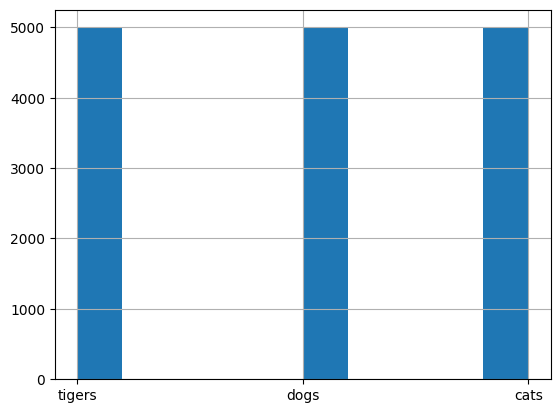

In [41]:
# membuat histogram untuk semua kategori pada class variable
dataset_df['label'].hist()

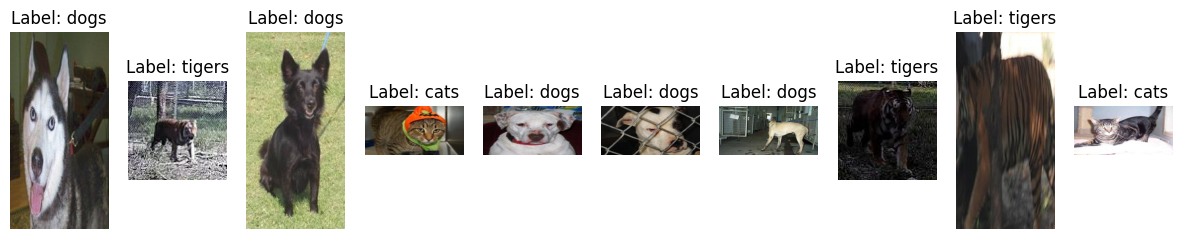

In [42]:
# Pilih hanya 9 gambar pertama (atau pilih subset lainnya jika diperlukan)
df_sample = dataset_df.sample(frac=1).reset_index(drop=True).head(10)

# Menampilkan gambar dan label
def display_images_with_labels(df):
    num_images = len(df)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    if num_images == 1:
        axes = [axes]  # Jika hanya satu gambar, axes tidak dalam bentuk list

    for ax, (idx, row) in zip(axes, df.iterrows()):
        img = mpimg.imread(row['filepath'])
        ax.imshow(img)
        ax.set_title(f'Label: {row["label"]}')
        ax.axis('off')  # Menghilangkan axis

    plt.show()

# Panggil fungsi untuk menampilkan gambar
display_images_with_labels(df_sample)

In [43]:
# menggunakan GPU untuk mengefisienkan waktu training model
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [45]:
class callback_model(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
            print("\n\nTarget tercapai\n")
            self.model.stop_training = True

def hewan():

    TRAINING_DIR = "/workspaces/Image-Classification-for-Cat-Dog-and-Tiger/submission/data"
    training_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        rotation_range=20,
        validation_split=0.2) # Dataset dibagi menjadi 80% train 20% validasi

    train_generator = training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(150,150),
        color_mode='rgb',
        class_mode='categorical',
        subset='training')

    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator= training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(150,150),
        color_mode='rgb',
        class_mode='categorical',
        subset='validation')

    model = tf.keras.models.Sequential([
        #layer1
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        #layer2
        tf.keras.layers.Conv2D(64, (4, 4), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        #layer3
        tf.keras.layers.Conv2D(128, (7, 7), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        #layer4
        tf.keras.layers.Conv2D(128, (8, 8), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        #Flatten
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        #Dense layer1
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        #Dense layer2
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        #output layer
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    callback = callback_model()

    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        epochs=1000,
        steps_per_epoch=20,
        validation_data=validation_generator,
        callbacks=callback,
        verbose=1,
        validation_steps=3)
    return model, history

In [ ]:
model, history = hewan()

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


/opt/conda/envs/.csn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-15 16:44:16.126786: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21233664 exceeds 10% of free system memory.
2025-02-15 16:44:16.163823: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21233664 exceeds 10% of free system memory.
2025-02-15 16:44:16.177517: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21233664 exceeds 10% of free system memory.
/opt/conda/envs/.csn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in it

Epoch 1/1000


2025-02-15 16:44:18.377691: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21233664 exceeds 10% of free system memory.
2025-02-15 16:44:18.422710: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21233664 exceeds 10% of free system memory.


20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.3512 - loss: 4.6030 - val_accuracy: 0.3542 - val_loss: 1.2962
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.4098 - loss: 2.5785 - val_accuracy: 0.3438 - val_loss: 1.3566
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.3897 - loss: 2.6893 - val_accuracy: 0.4479 - val_loss: 1.1746
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.4501 - loss: 1.8082 - val_accuracy: 0.4375 - val_loss: 1.1494
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 202s 10s/step - accuracy: 0.4170 - loss: 1.7260 - val_accuracy: 0.5000 - val_loss: 1.1809
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.4899 - loss: 1.5159 - val_accuracy: 0.5000 - val_loss: 1.1082
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.5066 - loss: 1.1870 - val_accuracy: 0.4583 - val_loss: 1.5594
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.5104 - loss: 1.1149 - val_accuracy: 0.4479